# Configure Cluster Module Params

This notebook should be used as a test for ensuring correct cluster parameters before cluster processing.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for cluster module

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

In [2]:
from pathlib import Path
import warnings

warnings.filterwarnings("ignore", category=UserWarning)  # filter Phate warnings

import yaml
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from lib.shared.file_utils import get_filename
from lib.cluster.cluster_eval import (
    plot_cell_histogram,
    plot_cluster_sizes,
    plot_bootstrap_filter_scatter,
    merge_bootstrap_with_genes,
    filter_genes_by_bootstrap,
    get_filtered_gene_list,
)
from lib.cluster.phate_leiden_clustering import (
    phate_leiden_pipeline,
    plot_phate_leiden_clusters,
)
from lib.cluster.benchmark_clusters import (
    evaluate_resolution,
    run_benchmark_analysis,
)
from lib.cluster.scrape_benchmarks import (
    get_uniprot_data,
    generate_string_pair_benchmark,
    generate_corum_group_benchmark,
    generate_msigdb_group_benchmark,
    filter_complexes,
)
from lib.shared.configuration_utils import CONFIG_FILE_HEADER

In [3]:
# load config file and determine root path
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)
    ROOT_FP = Path(config["all"]["root_fp"])

# load cell classes and channel combos
aggregate_combo_fp = config["aggregate"]["aggregate_combo_fp"]
aggregate_combos = pd.read_csv(aggregate_combo_fp, sep="\t")

CHANNEL_COMBOS = aggregate_combos["channel_combo"].unique().tolist()
print(f"Channel Combos: {CHANNEL_COMBOS}")

CELL_CLASSES = list(aggregate_combos["cell_class"].unique())
print(f"Cell classes: {CELL_CLASSES}")

Channel Combos: ['Hoescht_COX4_AGP_ConA']
Cell classes: ['all']


## <font color='red'>SET PARAMETERS</font>

### Cluster preprocessing

- `MIN_CELL_CUTOFFS`: Dictionary with minimum cells for each gene to be used in clusetering analysis. More cells per gene increases confidence, but some dataset types (ex mitotic) may have an inherently low number of cells for a particular perturbation. Ex `{"mitotic": 0, "interphase": 3, "all": 3}`.

In [4]:
MIN_CELL_CUTOFFS = {"all": 10}

PERTURBATION_NAME_COL = config["aggregate"]["perturbation_name_col"]

Cell count distribution for: all
Number of genes below cutoff: 2
['nontargeting_intergenic_CGTTCAGAGTGC', 'nontargeting_noncutting_CGTTAGGCTCTC']


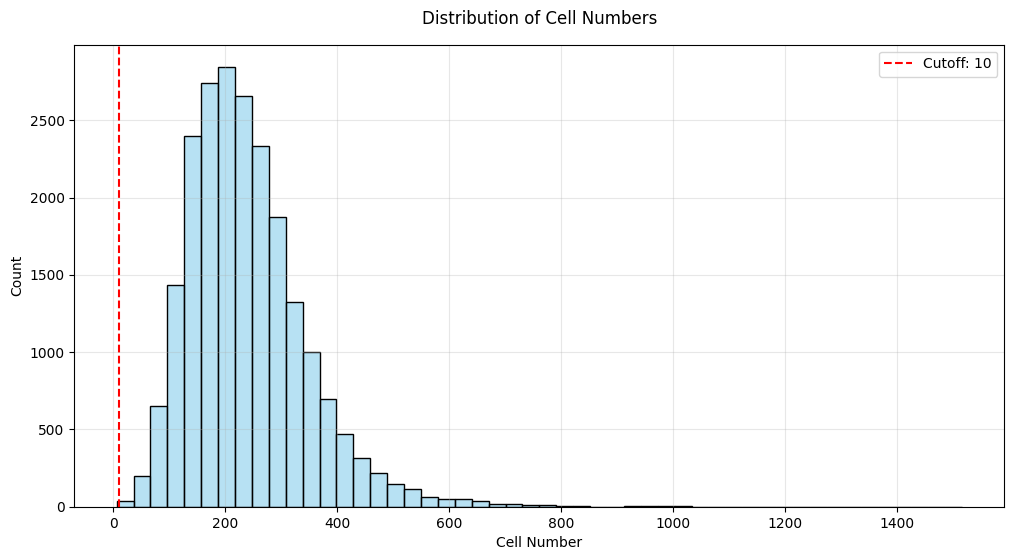

In [5]:
for cell_class, min_cell_cutoff in MIN_CELL_CUTOFFS.items():
    channel_combo = CHANNEL_COMBOS[0]
    aggregated_data_path = (
        ROOT_FP
        / "aggregate"
        / "tsvs"
        / get_filename(
            {"cell_class": cell_class, "channel_combo": channel_combo},
            "aggregated",
            "tsv",
        )
    )
    aggregated_data = pd.read_csv(aggregated_data_path, sep="\t")

    # show cell count distribution
    print(f"Cell count distribution for: {cell_class}")
    plot_cell_histogram(aggregated_data, min_cell_cutoff, PERTURBATION_NAME_COL)
    plt.show()

## <font color='red'>SET PARAMETERS</font>

### Benchmark Generation

- `STRING_PAIR_BENCHMARK_FP`: Path to save and access STRING pair benchmark.
- `CORUM_GROUP_BENCHMARK_FP`: Path to save and access CORUM group benchmark.
- `KEGG_GROUP_BENCHMARK_FP`: Path to save and access KEGG group benchmark.

**Note**: We use the following benchmark schemas:
- Pair Bechmark: `gene_name` column for gene matching with a cluster gene (or does not exist in cluster genes); `pair` column with a pair ID. Used to benchmark known pair relationships in generated cluster.
- Group Bechmark: `gene_name` column for gene matching with a cluster gene (or does not exist in cluster genes); `group` column with a group ID. Used to benchmark known group relationships in generated cluster, where a group represents genes involved in a pathway, protein complex, etc.

In [6]:
UNIPROT_DATA_FP = "config/benchmark_clusters/uniprot_data.tsv"
STRING_PAIR_BENCHMARK_FP = "config/benchmark_clusters/string_pair_benchmark.tsv"
CORUM_GROUP_BENCHMARK_FP = "config/benchmark_clusters/corum_group_benchmark.tsv"
KEGG_GROUP_BENCHMARK_FP = "config/benchmark_clusters/kegg_group_benchmark.tsv"

In [7]:
Path(STRING_PAIR_BENCHMARK_FP).parent.mkdir(parents=True, exist_ok=True)

uniprot_data = get_uniprot_data()
uniprot_data.to_csv(UNIPROT_DATA_FP, sep="\t", index=False)
uniprot_data = pd.read_csv(UNIPROT_DATA_FP, sep="\t")
display(uniprot_data)

string_pair_benchmark = generate_string_pair_benchmark(
    aggregated_data, uniprot_data, "gene_symbol_0"
)
string_pair_benchmark.to_csv(STRING_PAIR_BENCHMARK_FP, sep="\t", index=False)
string_pair_benchmark = pd.read_csv(STRING_PAIR_BENCHMARK_FP, sep="\t")
display(string_pair_benchmark)

corum_group_benchmark = generate_corum_group_benchmark()
corum_group_benchmark.to_csv(CORUM_GROUP_BENCHMARK_FP, sep="\t", index=False)
corum_group_benchmark = pd.read_csv(CORUM_GROUP_BENCHMARK_FP, sep="\t")
display(corum_group_benchmark)

kegg_group_benchmark = generate_msigdb_group_benchmark()
kegg_group_benchmark.to_csv(KEGG_GROUP_BENCHMARK_FP, sep="\t", index=False)
kegg_group_benchmark = pd.read_csv(KEGG_GROUP_BENCHMARK_FP, sep="\t")
display(kegg_group_benchmark)

Fetching UniProt data...
Completed. Total entries: 20460


,entry,gene_names,function,kegg,complexportal,string,link
0,A0A0C5B5G6,MT-RNR1,Regulates insulin sensitivity and metabolic ho...,NaN,NaN,NaN,https://www.uniprot.org/uniprotkb/A0A0C5B5G6/e...
1,A0A1B0GTW7,CIROP LMLN2,Putative metalloproteinase that plays a role i...,NaN,NaN,NaN,https://www.uniprot.org/uniprotkb/A0A1B0GTW7/e...
2,A0JNW5,BLTP3B KIAA0701 SHIP164 UHRF1BP1L,Tube-forming lipid transport protein which med...,hsa:23074;,NaN,9606.ENSP00000279907;,https://www.uniprot.org/uniprotkb/A0JNW5/entry
3,A0JP26,POTEB3,NaN,hsa:102724631;,NaN,9606.ENSP00000483103;,https://www.uniprot.org/uniprotkb/A0JP26/entry
4,A0PK11,CLRN2,Plays a key role to hearing function. Required...,hsa:645104;,NaN,9606.ENSP00000424711;,https://www.uniprot.org/uniprotkb/A0PK11/entry
...,...,...,...,...,...,...,...
20455,Q9H2U6,LINC00597 C15orf5,NaN,NaN,NaN,NaN,https://www.uniprot.org/uniprotkb/Q9H2U6/entry
20456,Q9H379,PRO3102,NaN,NaN,NaN,NaN,https://www.uniprot.org/uniprotkb/Q9H379/entry
20457,Q9P1C3,PRO2829,NaN,NaN,NaN,NaN,https://www.uniprot.org/uniprotkb/Q9P1C3/entry
20458,Q9UFV3,NaN,NaN,NaN,NaN,NaN,https://www.uniprot.org/uniprotkb/Q9UFV3/entry


Fetching STRING data...
Completed. Total interactions: 117118


,gene_name_variants,pair,gene_name
0,ARF5,1,ARF5
1,RAB11FIP3 ARFO1 KIAA0665,1,RAB11FIP3
2,M6PR MPR46 MPRD,2,M6PR
3,GGA3 KIAA0154,2,GGA3
4,M6PR MPR46 MPRD,3,M6PR
...,...,...,...
225791,LDB1 CLIM2,117116,LDB1
225792,RFXANK ANKRA1 RFXB,117117,RFXANK
225793,RFX7 RFXDC2,117117,RFX7
225794,RFX7 RFXDC2,117118,RFX7


Fetching CORUM data...


/home/matteodibernardo/miniconda3/envs/brieflow_whitney/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mips.helmholtz-muenchen.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Completed. Total complexes: 5513


,gene_name,group
0,BCL6,BCL6-HDAC4 complex
1,HDAC4,BCL6-HDAC4 complex
2,BCL6,BCL6-HDAC5 complex
3,HDAC5,BCL6-HDAC5 complex
4,BCL6,BCL6-HDAC7 complex
...,...,...
18669,LTK,LTK-IGF1R complex
18670,CD19,CD19-LYN complex
18671,LYN,CD19-LYN complex
18672,CD19,CD19-LCK complex


,gene_name,group
0,ACTB,KEGG_MEDICUS_REFERENCE_TIGHT_JUNCTION_ACTIN_SI...
1,ACTG1,KEGG_MEDICUS_REFERENCE_TIGHT_JUNCTION_ACTIN_SI...
2,ACTR2,KEGG_MEDICUS_REFERENCE_TIGHT_JUNCTION_ACTIN_SI...
3,ACTR3,KEGG_MEDICUS_REFERENCE_TIGHT_JUNCTION_ACTIN_SI...
4,ARPC1A,KEGG_MEDICUS_REFERENCE_TIGHT_JUNCTION_ACTIN_SI...
...,...,...
9657,LEF1,KEGG_MEDICUS_VARIANT_CDH1_REDUCED_EXPRESSION_T...
9658,MYC,KEGG_MEDICUS_VARIANT_CDH1_REDUCED_EXPRESSION_T...
9659,TCF7,KEGG_MEDICUS_VARIANT_CDH1_REDUCED_EXPRESSION_T...
9660,TCF7L1,KEGG_MEDICUS_VARIANT_CDH1_REDUCED_EXPRESSION_T...


## <font color='red'>SET PARAMETERS</font>

### Common Clustering Parameters

- `PHATE_DISTANCE_METRIC`: Distance metric used by phate during dimensionality reduction. Can be `euclidean` or `cosine`, `cosine` is recommended.
- `PERTURBATION_AUC_THRESHOLD`: AUC value used to filter out perturbations. Higher AUC value means more selective, usually `0.6`. Can be left as `None` for no filtering.

In [8]:
PHATE_DISTANCE_METRIC = "cosine"
PERTURBATION_AUC_THRESHOLD = None
CONTROL_KEY = config["aggregate"]["control_key"]

# Load aggregate wildcard combos for generating cluster combos
AGGREGATE_COMBO_FP = Path(config["aggregate"]["aggregate_combo_fp"])
aggregate_wildcard_combos = pd.read_csv(AGGREGATE_COMBO_FP, sep="\t")

## <font color='red'>SET PARAMETERS</font>

### Standard Clustering

Run PHATE + Leiden clustering on all genes (no bootstrap filtering).

- `STANDARD_CLUSTERING_ENABLED`: Enable standard clustering (True/False). Set to False if you only want filtered clustering.
- `STANDARD_CLUSTER_COMBO_FP`: Location of standard cluster combinations dataframe.
- `STANDARD_LEIDEN_RESOLUTIONS`: List of resolutions for standard Leiden clustering.

In [9]:
STANDARD_CLUSTERING_ENABLED = True
STANDARD_CLUSTER_COMBO_FP = "config/cluster_combo.tsv"
STANDARD_LEIDEN_RESOLUTIONS = [1, 5, 10, 20, 40, 60, 80, 100]

# Generate standard cluster combo file
if STANDARD_CLUSTERING_ENABLED and STANDARD_LEIDEN_RESOLUTIONS:
    standard_cluster_combos = aggregate_wildcard_combos[
        ["cell_class", "channel_combo"]
    ].drop_duplicates()
    standard_cluster_combos["leiden_resolution"] = [STANDARD_LEIDEN_RESOLUTIONS] * len(
        standard_cluster_combos
    )
    standard_cluster_combos = standard_cluster_combos.explode(
        "leiden_resolution", ignore_index=True
    )
    standard_cluster_combos.to_csv(STANDARD_CLUSTER_COMBO_FP, sep="\t", index=False)
    print("Standard cluster combos:")
    display(standard_cluster_combos)
else:
    print("Standard clustering disabled or no resolutions specified")

Standard cluster combos:


,cell_class,channel_combo,leiden_resolution
0,all,Hoescht_COX4_AGP_ConA,1
1,all,Hoescht_COX4_AGP_ConA,5
2,all,Hoescht_COX4_AGP_ConA,10
3,all,Hoescht_COX4_AGP_ConA,20
4,all,Hoescht_COX4_AGP_ConA,40
5,all,Hoescht_COX4_AGP_ConA,60
6,all,Hoescht_COX4_AGP_ConA,80
7,all,Hoescht_COX4_AGP_ConA,100


## <font color='red'>SET PARAMETERS</font>

### Filtered Clustering

Run PHATE + Leiden clustering on genes that pass bootstrap significance filtering.

- `FILTERED_CLUSTERING_ENABLED`: Enable filtered clustering (True/False)
- `FILTERED_CLUSTER_COMBO_FP`: Location of filtered cluster combinations dataframe.
- `FILTERED_LEIDEN_RESOLUTIONS`: List of resolutions for filtered clustering (can differ from standard).
- `CONTROL_PATTERNS`: List of regex patterns for nontargeting controls to ALWAYS include (e.g., `["^nontargeting_intergenic_", "^nontargeting_noncutting_"]`)
- `ZSCORE_THRESHOLD`: -log10(pval) threshold for significance (e.g., 2.0 = p < 0.01)
- `ZSCORE_DIRECTION`: Filter direction - "positive", "negative", or "both"
- `FDR_THRESHOLD`: FDR cutoff for multiple testing correction (e.g., 0.05)
- `FILTER_MODE`: How to combine filters - "zscore", "fdr", or "both"

In [ ]:
FILTERED_CLUSTERING_ENABLED = True
FILTERED_CLUSTER_COMBO_FP = "config/cluster_filtered_combo.tsv"
FILTERED_LEIDEN_RESOLUTIONS = [1, 5, 8, 10, 11, 12, 13, 14, 15, 16, 18, 20, 50, 100]

# Nontargeting control patterns to always include in filtered clustering
# These are regex patterns that match gene names to keep regardless of bootstrap results
CONTROL_PATTERNS = [
    "^nontargeting_intergenic_",
]

# Filter parameters
ZSCORE_THRESHOLD = 0.3
ZSCORE_DIRECTION = "both"  # "positive", "negative", or "both"
FDR_THRESHOLD = 0.5
FILTER_MODE = "both"  # "zscore", "fdr", or "both"

Filtered cluster combos:


,cell_class,channel_combo,leiden_resolution
0,all,Hoescht_COX4_AGP_ConA,1
1,all,Hoescht_COX4_AGP_ConA,5
2,all,Hoescht_COX4_AGP_ConA,8
3,all,Hoescht_COX4_AGP_ConA,10
4,all,Hoescht_COX4_AGP_ConA,11
5,all,Hoescht_COX4_AGP_ConA,12
6,all,Hoescht_COX4_AGP_ConA,13
7,all,Hoescht_COX4_AGP_ConA,14
8,all,Hoescht_COX4_AGP_ConA,15
9,all,Hoescht_COX4_AGP_ConA,16


## Visualize Bootstrap Filtering

Load bootstrap results and visualize which genes pass the filtering thresholds.

In [11]:
# Load bootstrap results and features_genes, merge and visualize filtering
TEST_CELL_CLASS = "all"
TEST_CHANNEL_COMBO = "Hoescht_COX4_AGP_ConA"

# Load aggregated data (used for actual clustering - has PCA features)
aggregated_data_path = (
    ROOT_FP
    / "aggregate"
    / "tsvs"
    / get_filename(
        {"cell_class": TEST_CELL_CLASS, "channel_combo": TEST_CHANNEL_COMBO},
        "aggregated",
        "tsv",
    )
)
aggregated_data = pd.read_csv(aggregated_data_path, sep="\t")
print(f"Loaded aggregated data: {len(aggregated_data)} genes")

# Load features_genes data (for merging with bootstrap results)
features_genes_path = (
    ROOT_FP
    / "aggregate"
    / "tsvs"
    / get_filename(
        {"cell_class": TEST_CELL_CLASS, "channel_combo": TEST_CHANNEL_COMBO},
        "features_genes",
        "tsv",
    )
)
features_genes = pd.read_csv(features_genes_path, sep="\t")
print(f"Loaded features_genes: {len(features_genes)} genes")

# Load bootstrap results
bootstrap_fp = (
    ROOT_FP
    / "aggregate"
    / "bootstrap"
    / get_filename(
        {"cell_class": TEST_CELL_CLASS, "channel_combo": TEST_CHANNEL_COMBO},
        "all_gene_bootstrap_results",
        "tsv",
    )
)

bootstrap_results = pd.read_csv(bootstrap_fp, sep="\t")
print(f"Loaded bootstrap results: {len(bootstrap_results)} genes")

Loaded aggregated data: 21732 genes
Loaded features_genes: 22544 genes
Loaded bootstrap results: 20920 genes


In [12]:
# Merge bootstrap with features_genes to identify which genes pass filter
merged_data = merge_bootstrap_with_genes(
    bootstrap_df=bootstrap_results,
    genes_df=features_genes,
    perturbation_name_col=PERTURBATION_NAME_COL,
    bootstrap_gene_col="gene",
)
print(f"Merged data: {len(merged_data)} genes")

# Get list of genes that pass filter
filtered_gene_list = get_filtered_gene_list(
    merged_data=merged_data,
    perturbation_name_col=PERTURBATION_NAME_COL,
    control_patterns=CONTROL_PATTERNS,
    zscore_threshold=ZSCORE_THRESHOLD,
    zscore_direction=ZSCORE_DIRECTION,
    fdr_threshold=FDR_THRESHOLD,
    filter_mode=FILTER_MODE,
)

# Filter the AGGREGATED data by gene (row-wise subset)
filtered_aggregated_data = aggregated_data[
    aggregated_data[PERTURBATION_NAME_COL].isin(filtered_gene_list)
].copy()

# Get filter stats for display
_, filter_stats = filter_genes_by_bootstrap(
    merged_data=merged_data,
    perturbation_name_col=PERTURBATION_NAME_COL,
    control_patterns=CONTROL_PATTERNS,
    zscore_threshold=ZSCORE_THRESHOLD,
    zscore_direction=ZSCORE_DIRECTION,
    fdr_threshold=FDR_THRESHOLD,
    filter_mode=FILTER_MODE,
)

filter_stats

Merged data: 22544 genes


{'total_genes': 22544,
 'pass_zscore': 7352,
 'pass_fdr': 3334,
 'pass_combined': 3134,
 'num_controls': 900,
 'final_filtered': 4029,
 'num_features_tested': 39}

In [13]:
SIGNIFICANT_GENES_FP = "config/significant_genes.tsv"

# Write gene_symbol_0 from filtered_aggregated_data
pd.DataFrame({"gene": filtered_aggregated_data["gene_symbol_0"]}).to_csv(
    SIGNIFICANT_GENES_FP, sep="\t", index=False
)

print(f"Wrote {len(filtered_aggregated_data)} significant genes to {SIGNIFICANT_GENES_FP}")

Wrote 3716 significant genes to config/significant_genes.tsv


## Resolution Benchmarking

Evaluate different Leiden resolutions for both standard (full) and filtered clustering approaches using CORUM benchmark.

In [14]:
# Prepare both standard and filtered datasets for resolution evaluation
# Standard (full) data - use aggregated data (has PCA features for clustering)
standard_data = aggregated_data.copy()
print(f"Standard clustering data: {len(standard_data)} genes")

# Filtered data - use filtered aggregated data from bootstrap filtering above
if filtered_aggregated_data is not None:
    filtered_data = filtered_aggregated_data.copy()
    print(f"Filtered clustering data: {len(filtered_data)} genes")
else:
    filtered_data = None
    print("Filtered data not available (bootstrap results missing)")

Standard clustering data: 21732 genes
Filtered clustering data: 3716 genes


STANDARD CLUSTERING - Resolution Evaluation
Creating clusters for resolution: 1
Creating clusters for resolution: 5


OpenBLAS warning: precompiled NUM_THREADS exceeded, adding auxiliary array for thread metadata.
To avoid this warning, please rebuild your copy of OpenBLAS with a larger NUM_THREADS setting
or set the environment variable OPENBLAS_NUM_THREADS to 64 or lower


Creating clusters for resolution: 10
Creating clusters for resolution: 20
Creating clusters for resolution: 40
Creating clusters for resolution: 60
Creating clusters for resolution: 80
Creating clusters for resolution: 100


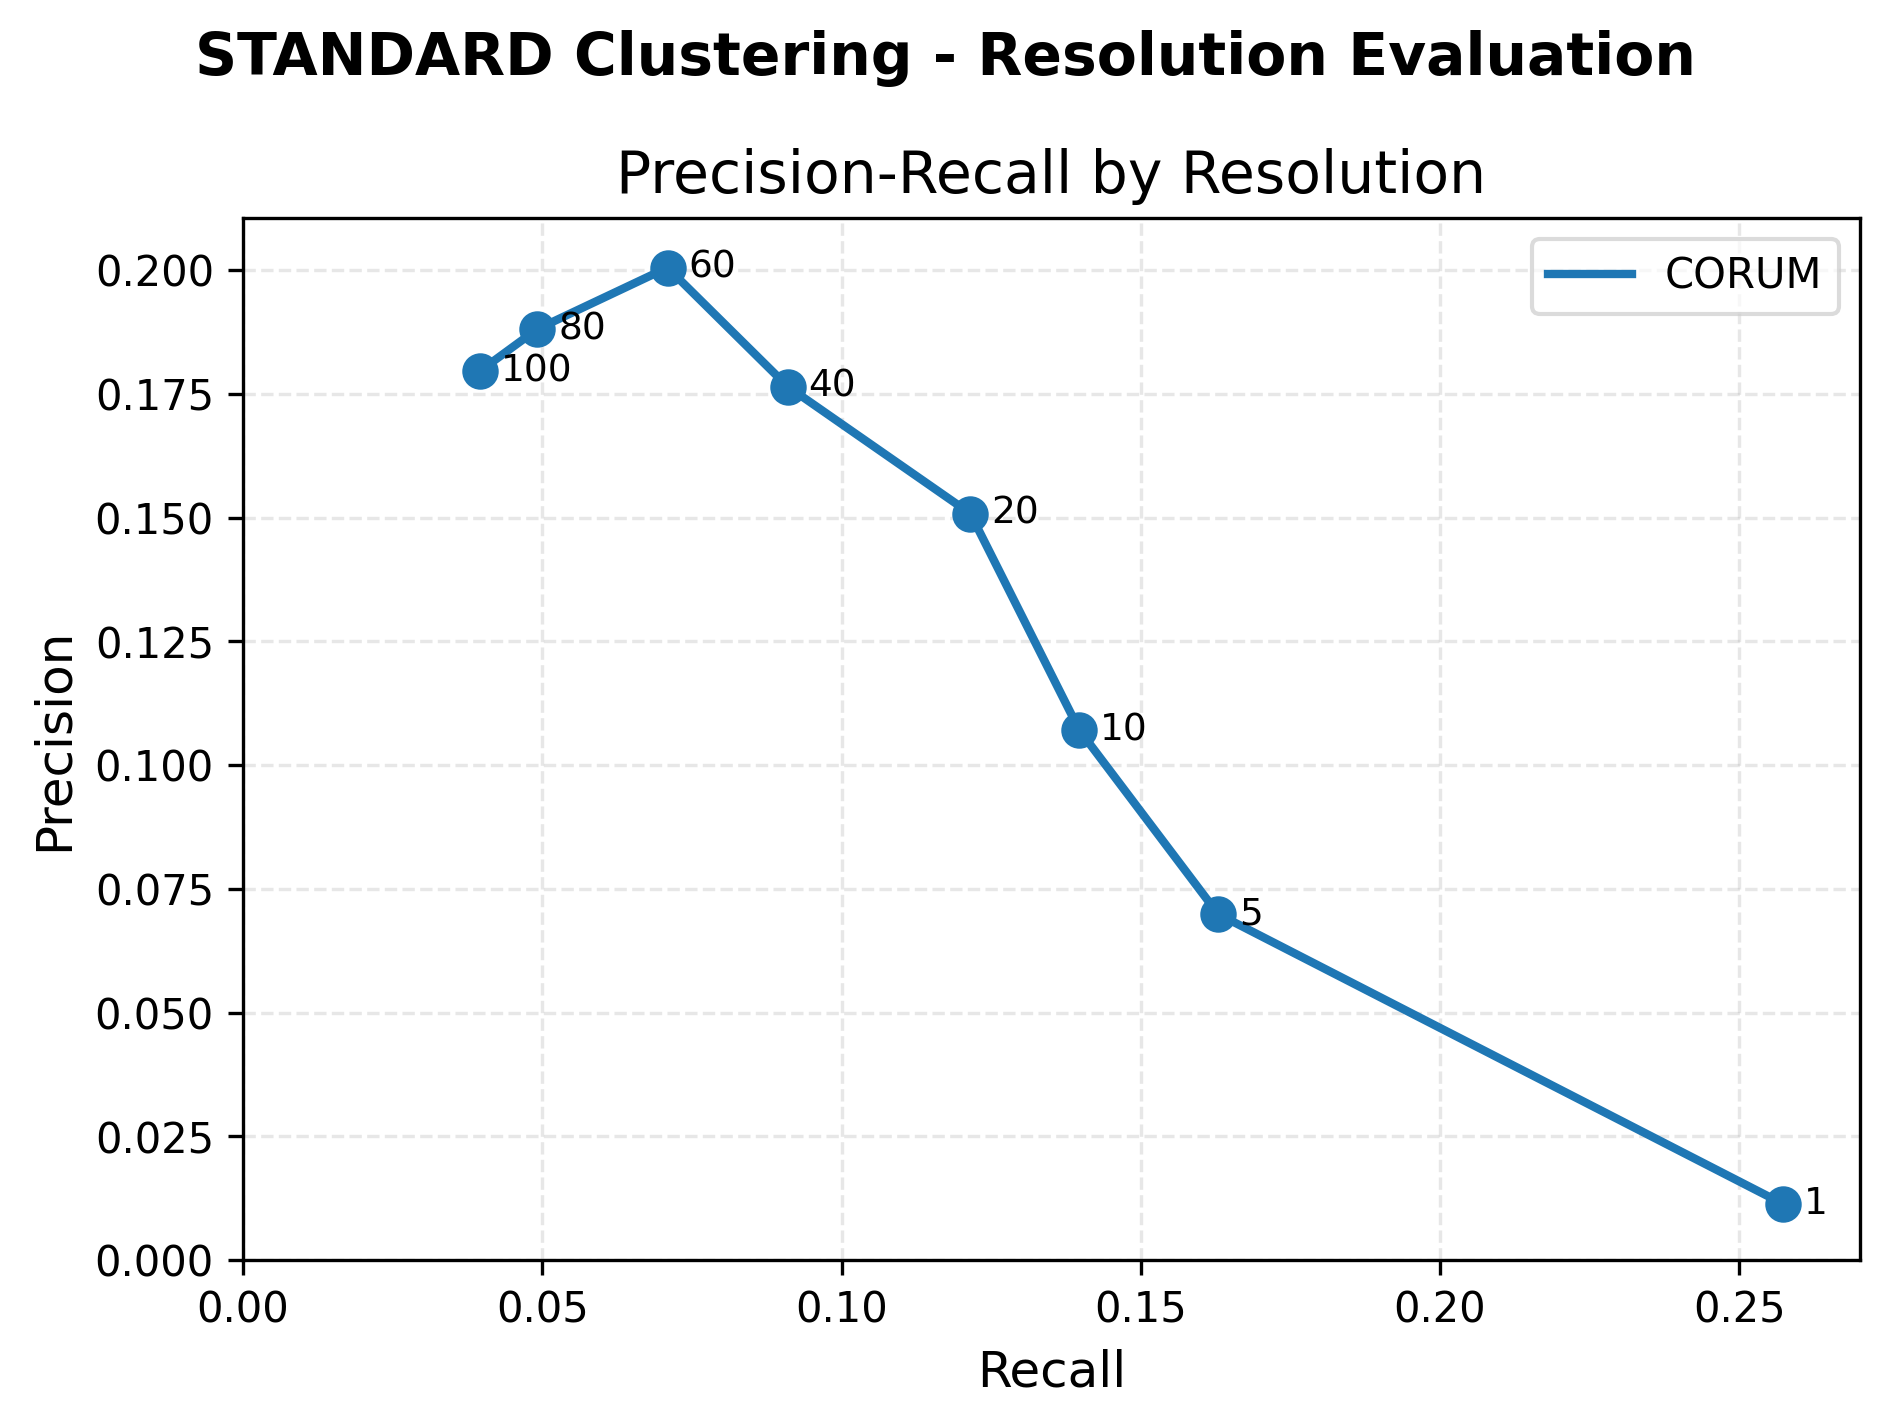


Standard clustering results:


,resolution,num_clusters,precision,recall,f1_score,benchmark
0,1,47,0.011370,0.257303,0.021777,CORUM
1,5,452,0.069912,0.162923,0.097840,CORUM
2,10,782,0.107069,0.139731,0.121239,CORUM
3,20,1248,0.150833,0.121518,0.134598,CORUM
4,40,1979,0.176471,0.091025,0.120101,CORUM
5,60,2546,0.200508,0.070916,0.104775,CORUM
6,80,3009,0.188080,0.049145,0.077927,CORUM
7,100,3344,0.179651,0.039605,0.064902,CORUM


In [15]:
# Evaluate resolutions for STANDARD clustering
print("=" * 60)
print("STANDARD CLUSTERING - Resolution Evaluation")
print("=" * 60)

group_benchmarks = {"CORUM": corum_group_benchmark}

standard_results_df, standard_fig = evaluate_resolution(
    standard_data,
    PHATE_DISTANCE_METRIC,
    STANDARD_LEIDEN_RESOLUTIONS,
    group_benchmarks,
    PERTURBATION_NAME_COL,
    CONTROL_KEY,
)

plt.figure(standard_fig.number)
plt.suptitle("STANDARD Clustering - Resolution Evaluation", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nStandard clustering results:")
display(standard_results_df)

FILTERED CLUSTERING - Resolution Evaluation
Creating clusters for resolution: 1
Creating clusters for resolution: 5
Creating clusters for resolution: 8
Creating clusters for resolution: 10
Creating clusters for resolution: 11
Creating clusters for resolution: 12
Creating clusters for resolution: 13
Creating clusters for resolution: 14
Creating clusters for resolution: 15
Creating clusters for resolution: 16
Creating clusters for resolution: 18
Creating clusters for resolution: 20
Creating clusters for resolution: 50
Creating clusters for resolution: 100


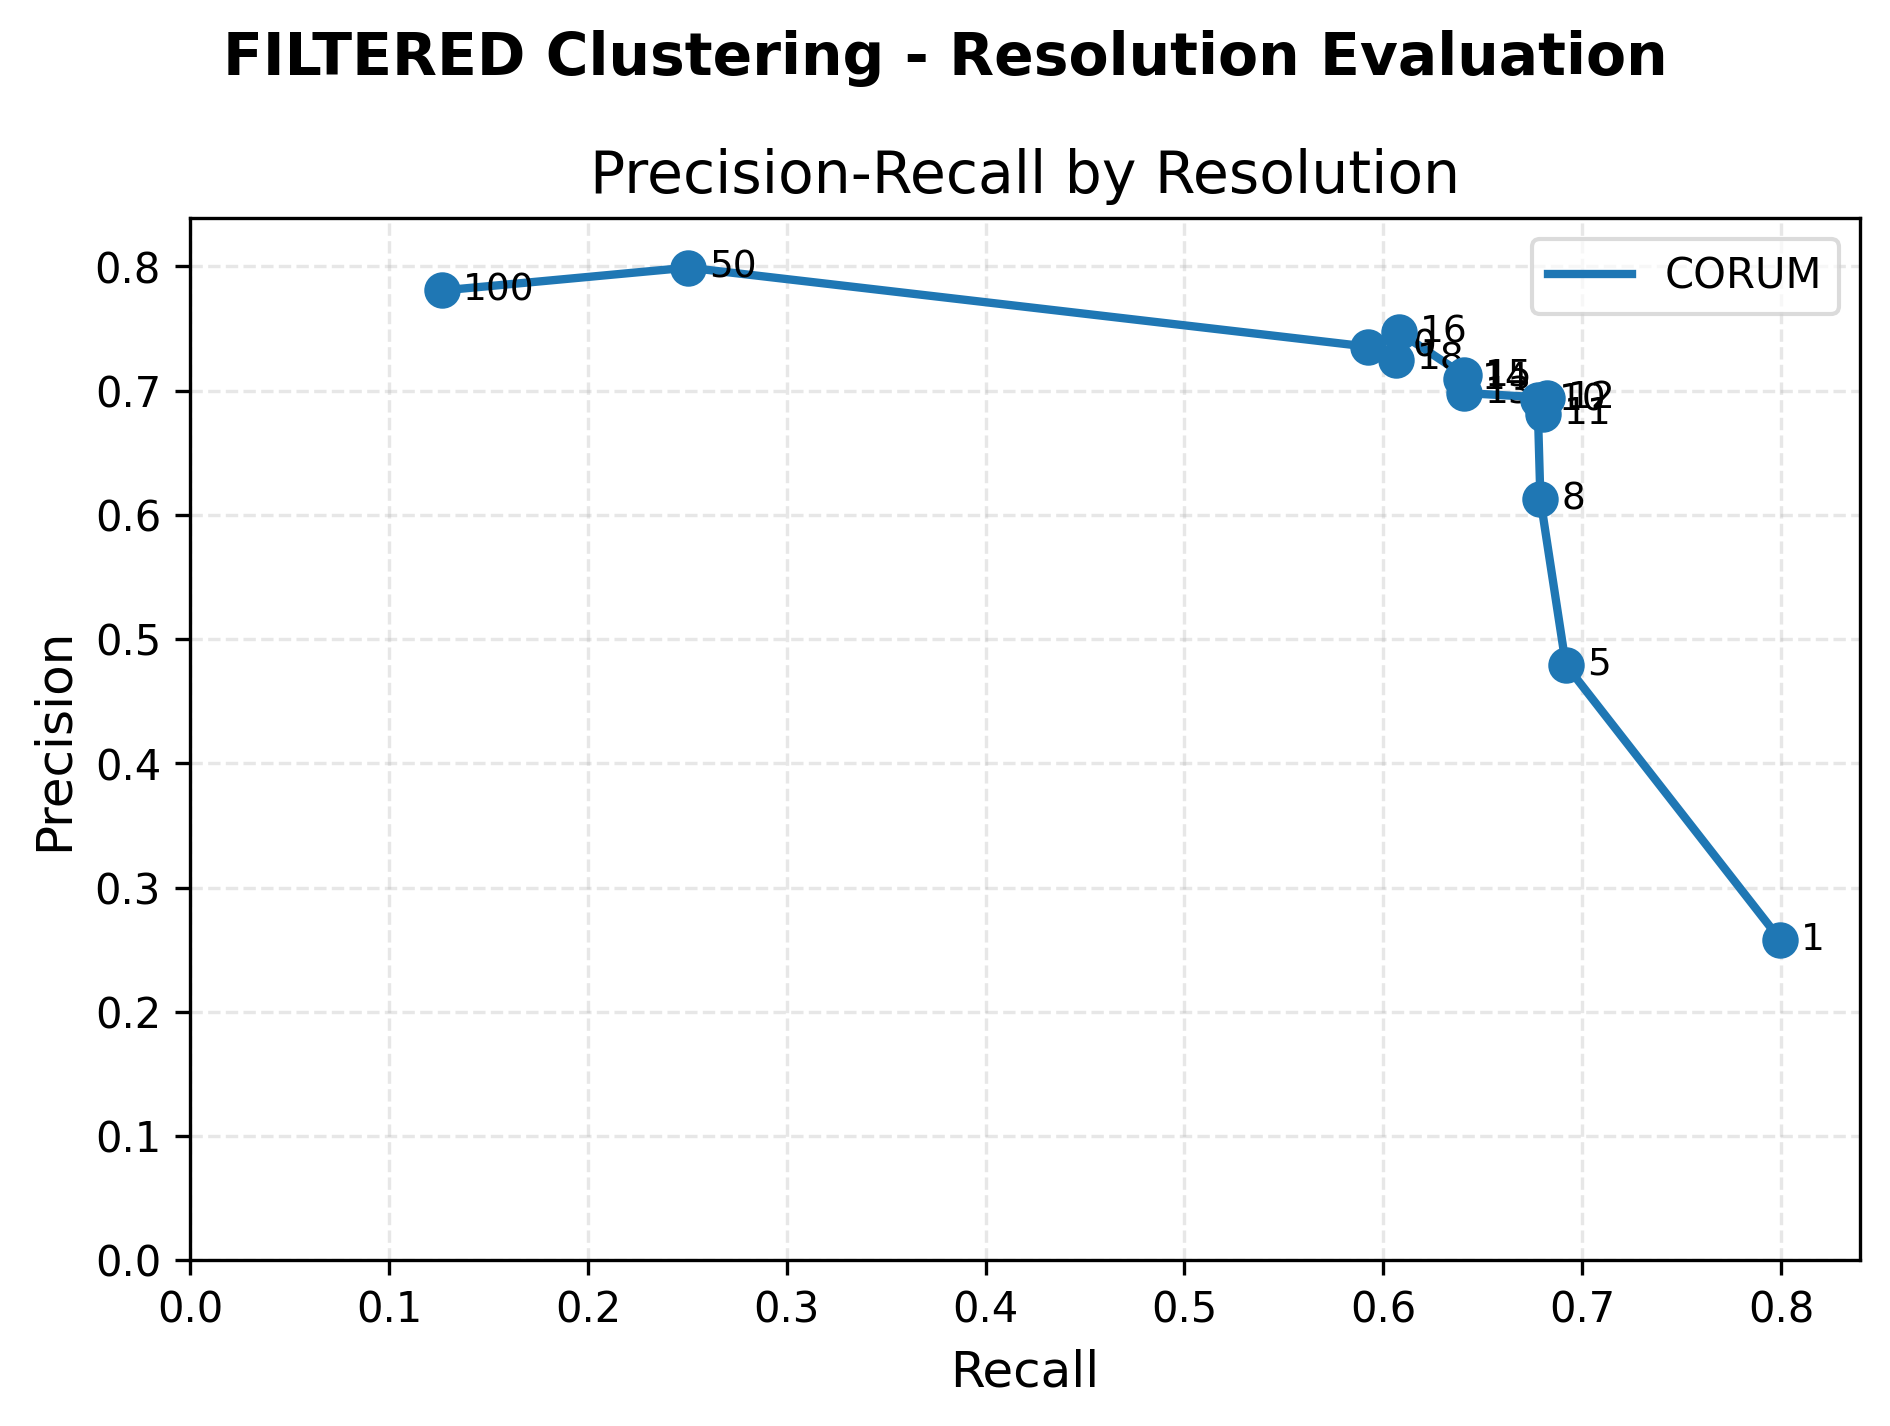


Filtered clustering results:


,resolution,num_clusters,precision,recall,f1_score,benchmark
0,1,27,0.257722,0.799714,0.389819,CORUM
1,5,189,0.479331,0.691761,0.566279,CORUM
2,8,271,0.612821,0.678977,0.644205,CORUM
3,10,323,0.692308,0.677557,0.684853,CORUM
4,11,351,0.681366,0.680398,0.680881,CORUM
5,12,368,0.694323,0.682403,0.688312,CORUM
6,13,386,0.698142,0.640625,0.668148,CORUM
7,14,407,0.709779,0.639205,0.672646,CORUM
8,15,430,0.712480,0.640625,0.674645,CORUM
9,16,443,0.746946,0.607955,0.670321,CORUM


In [16]:
print("=" * 60)
print("FILTERED CLUSTERING - Resolution Evaluation")
print("=" * 60)

filtered_results_df, filtered_fig = evaluate_resolution(
    filtered_data,
    PHATE_DISTANCE_METRIC,
    FILTERED_LEIDEN_RESOLUTIONS,
    group_benchmarks,
    PERTURBATION_NAME_COL,
    CONTROL_KEY,
)

plt.figure(filtered_fig.number)
plt.suptitle("FILTERED Clustering - Resolution Evaluation", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nFiltered clustering results:")
display(filtered_results_df)

In [ ]:
FILTERED_LEIDEN_RESOLUTIONS = [10, 11, 12, 13, 14, 15]

# Generate filtered cluster combo file
if FILTERED_CLUSTERING_ENABLED and FILTERED_LEIDEN_RESOLUTIONS:
    filtered_cluster_combos = aggregate_wildcard_combos[
        ["cell_class", "channel_combo"]
    ].drop_duplicates()
    filtered_cluster_combos["leiden_resolution"] = [FILTERED_LEIDEN_RESOLUTIONS] * len(
        filtered_cluster_combos
    )
    filtered_cluster_combos = filtered_cluster_combos.explode(
        "leiden_resolution", ignore_index=True
    )
    filtered_cluster_combos.to_csv(FILTERED_CLUSTER_COMBO_FP, sep="\t", index=False)
    print("Filtered cluster combos:")
    display(filtered_cluster_combos)
else:
    print("Filtered clustering disabled or no resolutions specified")

## Test Clustering

Test either standard or filtered clustering at a single resolution before running the full snakemake pipeline.

- `TEST_CELL_CLASS`: Cell class to test on
- `TEST_CHANNEL_COMBO`: Channel combo to test on  
- `TEST_LEIDEN_RESOLUTION`: Single resolution to test
- `TEST_USE_FILTERED`: Set to True to test filtered clustering, False for standard

In [22]:
TEST_CELL_CLASS = "all"
TEST_CHANNEL_COMBO = "Hoescht_COX4_AGP_ConA"
TEST_LEIDEN_RESOLUTION = 10
TEST_USE_FILTERED = True

In [23]:
# Load data for testing based on TEST_USE_FILTERED toggle
# Uses aggregated data (with PCA features) for actual clustering
if TEST_USE_FILTERED:
    # Use filtered_aggregated_data from bootstrap filtering section above
    if filtered_aggregated_data is not None:
        test_data = filtered_aggregated_data.copy()
        print(f"FILTERED clustering test: {len(test_data)} genes")
        print(f"  (from {filter_stats['total_genes']} total, {filter_stats['pass_combined']} significant + {filter_stats['num_controls']} controls)")
    else:
        print("ERROR: filtered_aggregated_data not available. Run bootstrap filtering section first.")
        test_data = aggregated_data.copy()
        print(f"Falling back to STANDARD clustering: {len(test_data)} genes")
else:
    test_data = aggregated_data.copy()
    print(f"STANDARD clustering test: {len(test_data)} genes")

FILTERED clustering test: 3716 genes
  (from 22544 total, 3134 significant + 900 controls)


FILTERED clustering at resolution 10:
  Total genes: 3716
  Number of clusters: 323


,gene_symbol_0,cell_count,PHATE_0,PHATE_1,cluster,uniprot_entry,uniprot_function,uniprot_link
0,ENSG00000241962,512,0.016524,0.022729,0,NaN,NaN,NaN
1,ATP5MF-PTCD1,446,0.014791,0.019487,0,NaN,NaN,NaN
2,MTPAP,459,0.017782,0.026669,0,Q9NVV4,Polymerase that creates the 3' poly(A) tail of...,https://www.uniprot.org/uniprotkb/Q9NVV4/entry
3,MRPS31,282,0.018568,0.027109,0,Q92665,NaN,https://www.uniprot.org/uniprotkb/Q92665/entry
4,PNPT1,345,0.015498,0.021778,0,Q8TCS8,RNA-binding protein implicated in numerous RNA...,https://www.uniprot.org/uniprotkb/Q8TCS8/entry


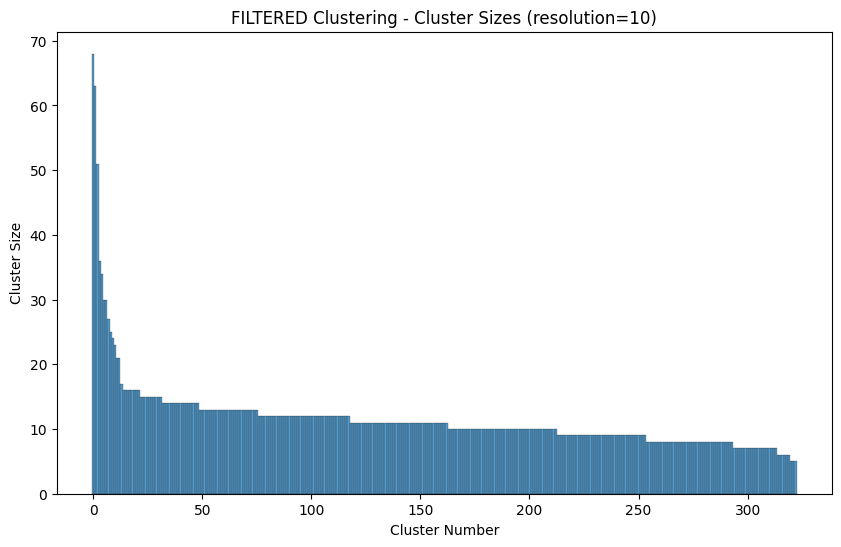

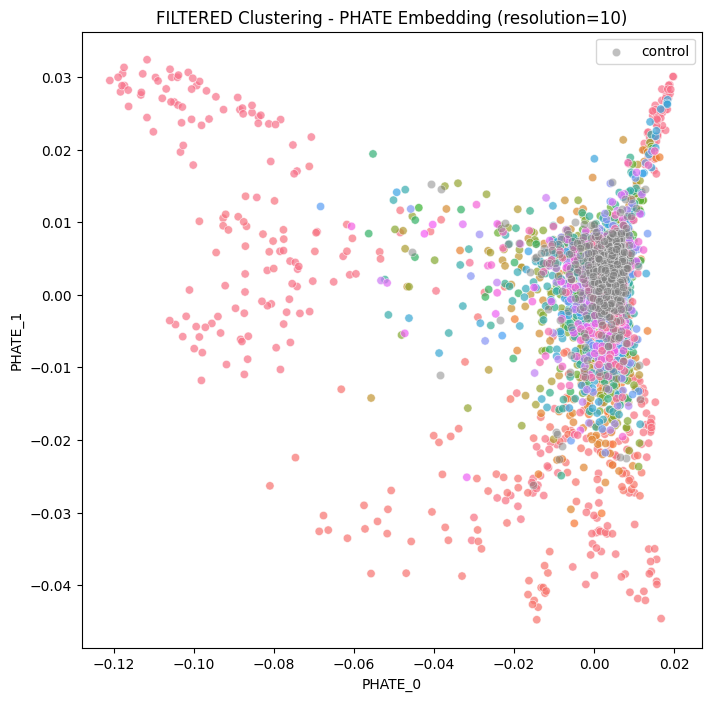

In [24]:
# Run PHATE + Leiden clustering
phate_leiden_clustering = phate_leiden_pipeline(
    test_data,
    TEST_LEIDEN_RESOLUTION,
    PHATE_DISTANCE_METRIC,
)

# Add uniprot annotations
uniprot_data["gene_name"] = uniprot_data["gene_names"].str.split().str[0]
uniprot_data = uniprot_data.drop_duplicates("gene_name", keep="first")
uniprot_subset = uniprot_data[["gene_name", "entry", "function", "link"]].rename(
    columns={
        "entry": "uniprot_entry",
        "function": "uniprot_function",
        "link": "uniprot_link",
    }
)
phate_leiden_clustering = phate_leiden_clustering.merge(
    uniprot_subset, how="left", left_on=PERTURBATION_NAME_COL, right_on="gene_name"
).drop(columns="gene_name")

clustering_type = "FILTERED" if TEST_USE_FILTERED else "STANDARD"
print(f"{clustering_type} clustering at resolution {TEST_LEIDEN_RESOLUTION}:")
print(f"  Total genes: {len(phate_leiden_clustering)}")
print(f"  Number of clusters: {phate_leiden_clustering['cluster'].nunique()}")
display(phate_leiden_clustering.head())

cluster_size_fig = plot_cluster_sizes(phate_leiden_clustering)
plt.title(f"{clustering_type} Clustering - Cluster Sizes (resolution={TEST_LEIDEN_RESOLUTION})")
plt.show()

clusters_fig = plot_phate_leiden_clusters(
    phate_leiden_clustering, PERTURBATION_NAME_COL, CONTROL_KEY
)
plt.title(f"{clustering_type} Clustering - PHATE Embedding (resolution={TEST_LEIDEN_RESOLUTION})")
plt.show()

FILTERED Clustering Benchmark Results:
Running integrated benchmarks...
Processing dataset: Real
  - Running STRING pair benchmark
  - Running CORUM group benchmark
  - Running KEGG group benchmark
Processing dataset: Shuffled
  - Running STRING pair benchmark
  - Running CORUM group benchmark
  - Running KEGG group benchmark
Generating combined tables...
Generating visualizations...

Summary Metrics:

Real:
  CORUM num enriched clusters: 14
  CORUM proportion enriched clusters: 0.04
  KEGG num enriched clusters: 9
  KEGG proportion enriched clusters: 0.03
  STRING precision: 0.1001
  STRING recall: 0.2770
  STRING F1 score: 0.1471

Shuffled:
  CORUM num enriched clusters: 0
  CORUM proportion enriched clusters: 0.00
  KEGG num enriched clusters: 1
  KEGG proportion enriched clusters: 0.00
  STRING precision: 0.0014
  STRING recall: 0.0025
  STRING F1 score: 0.0018


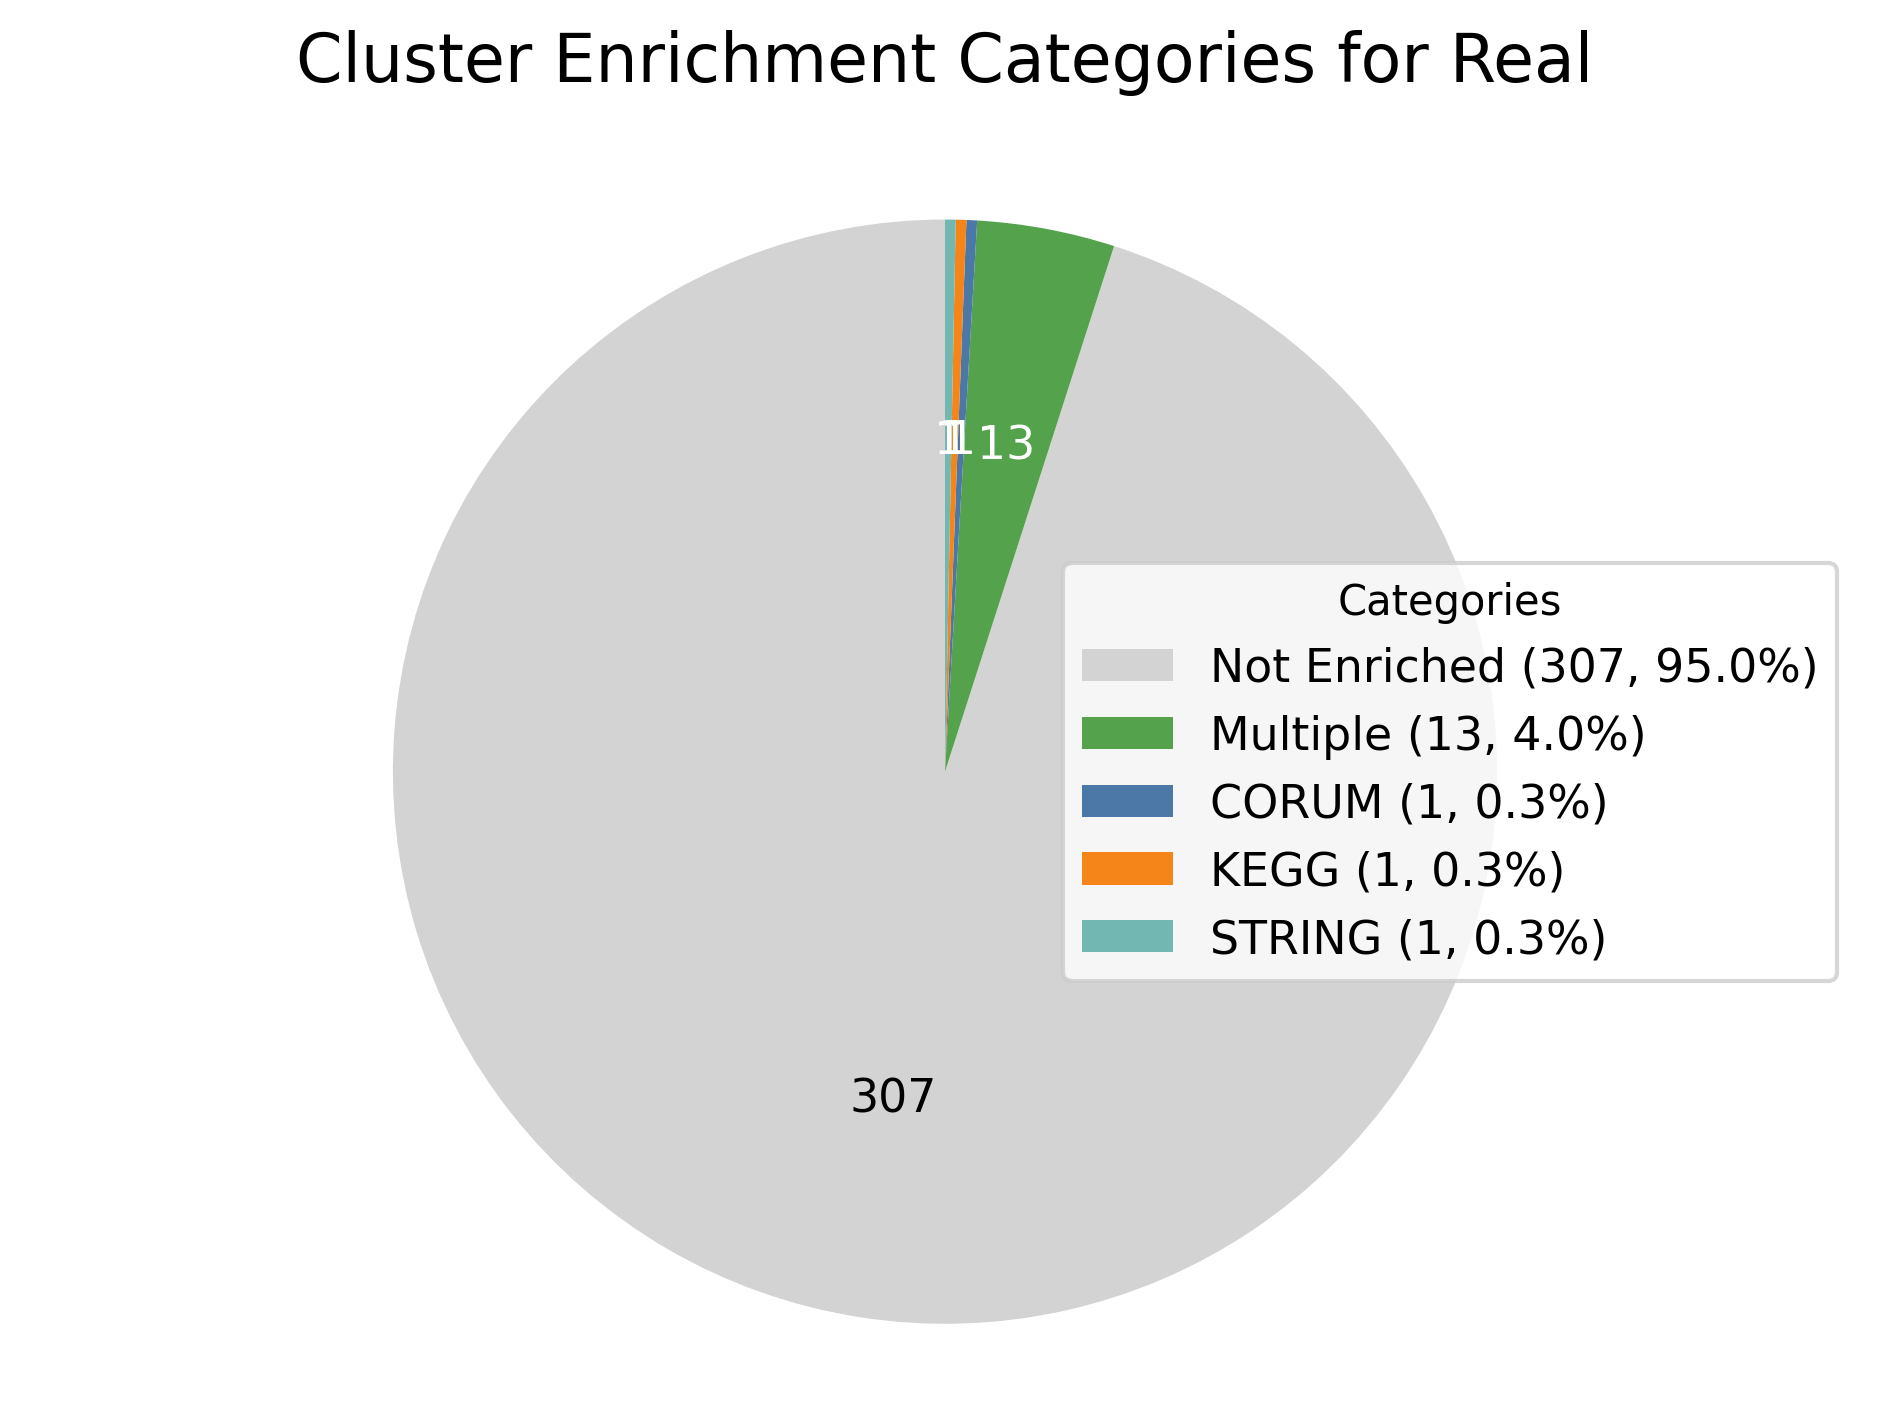

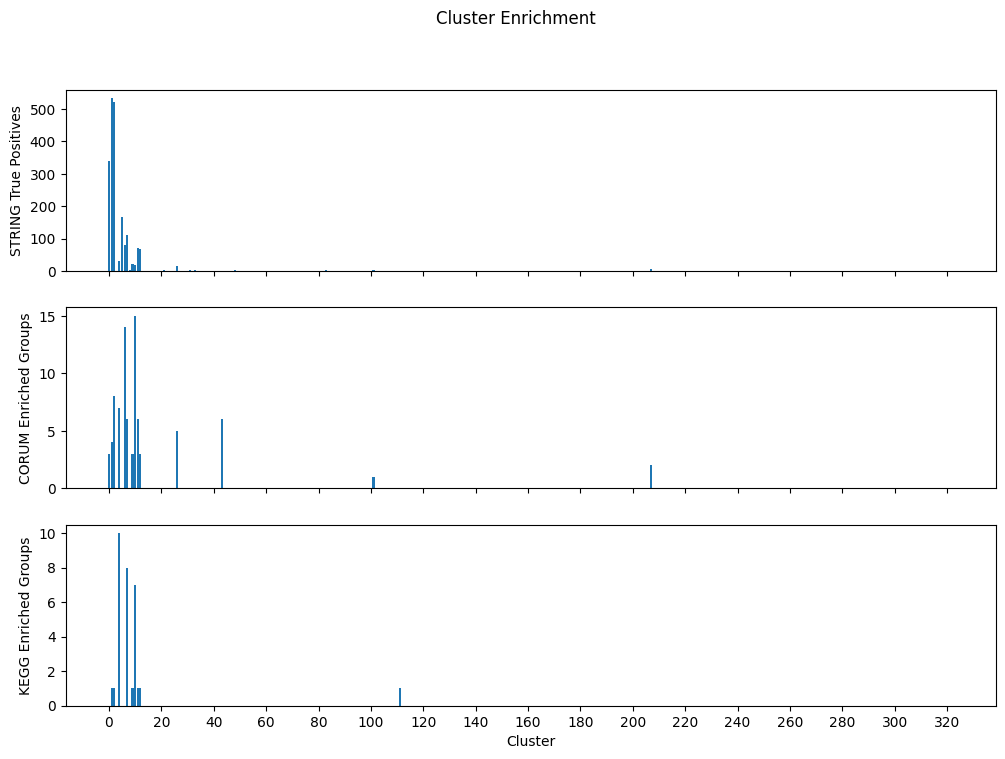

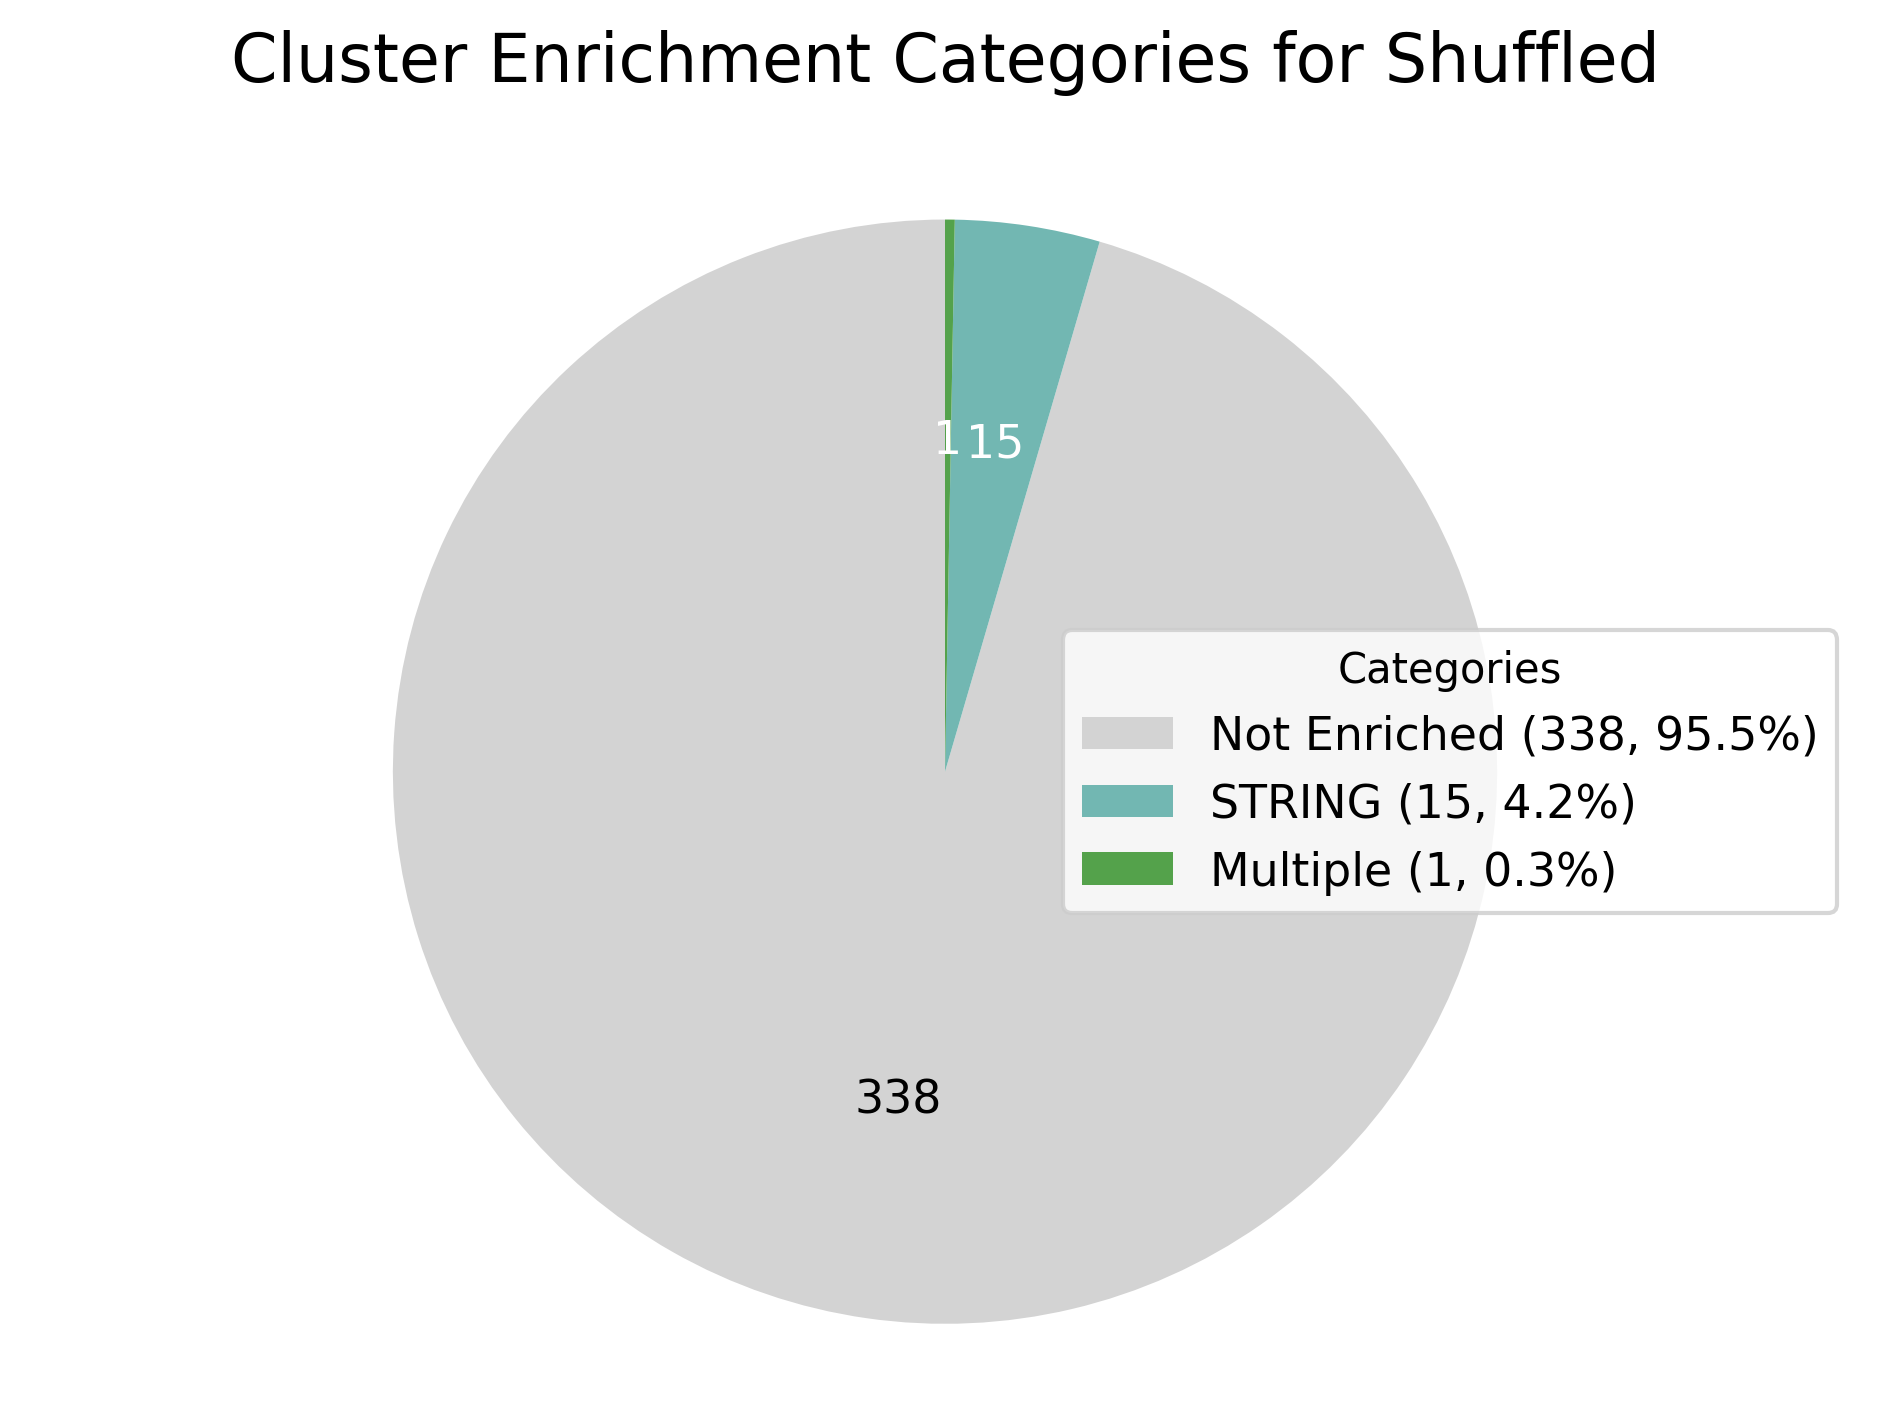

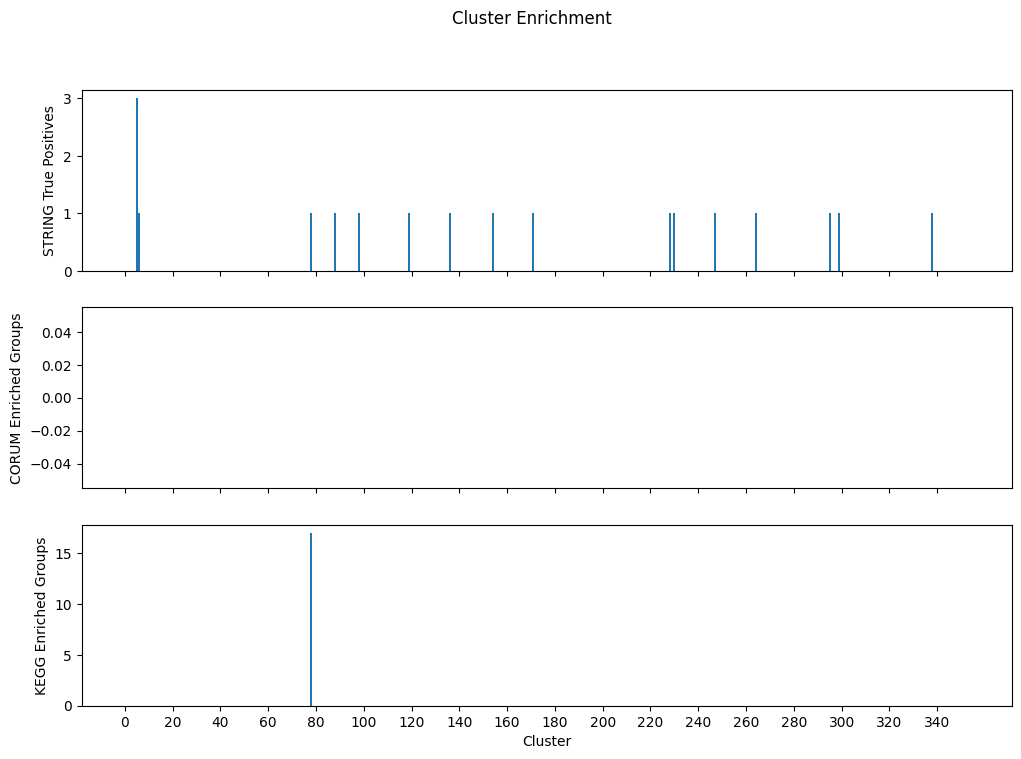

In [25]:
# Benchmark the test clustering
# Create shuffled baseline for comparison
shuffled_data = test_data.copy()
feature_start_idx = shuffled_data.columns.get_loc("PC_0")
feature_cols = shuffled_data.columns[feature_start_idx:]
for col in feature_cols:
    shuffled_data[col] = np.random.permutation(shuffled_data[col].values)

phate_leiden_shuffled = phate_leiden_pipeline(
    shuffled_data,
    TEST_LEIDEN_RESOLUTION,
    PHATE_DISTANCE_METRIC,
)

cluster_datasets = {
    "Real": phate_leiden_clustering,
    "Shuffled": phate_leiden_shuffled,
}

clustering_type = "FILTERED" if TEST_USE_FILTERED else "STANDARD"
print(f"{clustering_type} Clustering Benchmark Results:")
(
    integrated_results,
    combined_tables,
    global_metrics,
    pie_charts,
    cluster_enrichment_plots,
) = run_benchmark_analysis(
    cluster_datasets,
    string_pair_benchmark,
    corum_group_benchmark,
    kegg_group_benchmark,
    PERTURBATION_NAME_COL,
    CONTROL_KEY,
)

## Add cluster parameters to config file

Run this cell to save all cluster parameters to the config file.

In [21]:
# Add cluster section
config["cluster"] = {
    "min_cell_cutoffs": MIN_CELL_CUTOFFS,
    "phate_distance_metric": PHATE_DISTANCE_METRIC,
    "perturbation_auc_threshold": PERTURBATION_AUC_THRESHOLD,
    "uniprot_data_fp": UNIPROT_DATA_FP,
    "string_pair_benchmark_fp": STRING_PAIR_BENCHMARK_FP,
    "corum_group_benchmark_fp": CORUM_GROUP_BENCHMARK_FP,
    "kegg_group_benchmark_fp": KEGG_GROUP_BENCHMARK_FP,
    # Standard clustering configuration
    "standard_clustering": {
        "enabled": STANDARD_CLUSTERING_ENABLED,
        "cluster_combo_fp": STANDARD_CLUSTER_COMBO_FP,
    },
    # Filtered clustering configuration
    "filtered_clustering": {
        "enabled": FILTERED_CLUSTERING_ENABLED,
        "cluster_filtered_combo_fp": FILTERED_CLUSTER_COMBO_FP,
        "significant_genes_fp": SIGNIFICANT_GENES_FP,
    },
}

# Write the updated configuration
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False, sort_keys=False)

print("Config file updated with cluster parameters!")

Config file updated with cluster parameters!
